#Taller 3 Machine Learning Kernels and SVM’s
#$Integrantes$:
>Juan Felipe Baquero Vargas

>Lina Fernanda Rosales Castro




Se realizan los imports necesarios para la actividad

In [1]:
%matplotlib inline
import sklearn as skl
import numpy as np
import pylab as pl
import pandas as pd
from IPython.display import display, Math, Latex
from sklearn import svm

In [2]:
def doPlot( prediccion, realVal, labels, ordenar=1, tieneX=0,ejeX=1,labelX='X', labelY='Y', titulo='Gafica'):
    if ordenar==1:
        pred = sorted( prediccion , reverse=True)
        vals = sorted( realVal , reverse=True)
    else:
        pred = prediccion 
        vals = realVal 
    #print ejeX
    if tieneX==0:
        ejeX = np.arange( len(pred) )
    #print ejeX
    pl.clf()
    pl.title( titulo );
    pl.plot(ejeX, pred, 'gx', label=labels[0])
    pl.plot(ejeX, vals, 'r.', label=labels[1])
    pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    pl.xlabel( labelX )
    pl.ylabel( labelY )
    pl.show()

El error en el segundo punto se va a calcular usando Square Means

In [3]:
def calcularError( prediccion, valReal):
    pred = prediccion
    vals = valReal
    dif = np.dot(pred-vals, pred-vals)*1.0/pred.shape[0]
    return dif

In [4]:
#Separa label de dato.
def separarDatos( datos ):
    lab = [ data[0] for data in datos]
    dato = [ data[1:] for data in datos]
    return lab, dato

##Punto 1

###A - Expresión utilizando kernerls


Dado un vecto $w$ en $X$, calcular la norma de la proyección de la imagen en un punto $x$,$\phi(x)$ en la imagen del vector $w$, $\phi(w)$:

$$P_{\phi(w)}\left(\phi(x)\right)=\frac{\langle\phi(x),\phi(y)\rangle}{\Vert\phi(w)\Vert}$$

Por la definición de kernel y la defición de la norma como producto punto: 
$\Vert x\Vert = \langle x, x\rangle^\frac{1}{2}$, se tiene que:
$$P_{\phi(w)}\left(\phi(x)\right)= \frac{ k(x,w)}{ k(w,w)^{\frac{1}{2}}}$$


### B - Varianza de las proyecciones

Calcular la varianza de las proyeciones en un espacio de un conjunto de puntos a lo largo de un vector $w$:
$$\mathrm{Var}_{\phi(w)}(x) = \frac{1}{n}\sum_{x_i\in x}\left( P_{\phi(w)}(\phi(x_i))-\mu \right)^2$$

donde

$$\mu = \frac{1}{n}\sum_{x_i\in x} P_{\phi(w)}(\phi(x_i))$$

Utilizando el resultado del literal A se tiene que:
 
 $$\mathrm{Var}_{\phi(w)}(x) = \frac{1}{n}\sum_{x_i\in x}\left( \frac{ k(x,w)}{ k(w,w)^{-\frac{1}{2}}})-\mu \right)^2$$
 
 donde 

$$\mu = \frac{1}{n k(w,w)^{\frac{1}{2}}}\sum_{x_i\in x} k(x_i,w)$$

###C - Implementacion en Python

In [9]:
#Definiciòn de kernels
def kernel1(x,w):
    return np.dot(x,w)

def kernel2(x,w):
    return np.dot(x,w)**2

def kernel3(x,w):
    return (np.dot(x,w) + 1)**5

def kernel4(x,w):
    aux = x - w
    return np.exp(-0.5 *np.dot(aux,aux))

#Varianza y proyeccion
def projection(x,w,k):
    return (k(x,w)/(k(w,w)**.5))

def variance(xs, w, k):
    n = len(xs)
    proj = np.array([projection(x,w,k) for x in xs])
    m = np.mean(proj)
    
    rest = (proj - m)**2
    
    suma = np.sum(rest)

    return (1.0/n)*suma
    
    

In [10]:
xs = np.array([[ 0,  1], 
               [-1,  3],
               [ 2,  4],
               [ 3, -1],
               [-1, -2]])

w1 = np.array([ 1, 1])

w2 = np.array([ -1, 1])

ks = [kernel1,kernel2,kernel3,kernel4]

In [11]:
wk1 = []
wk2 = []

for idx in xrange(len(ks)):
    wk1.append((variance(xs,w1,ks[idx])))


for idx in xrange(len(ks)):
    wk2.append(variance(xs,w2,ks[idx]))

wk1=np.array(wk1)
wk2=np.array(wk2)

wk1 = wk1.T
wk2= wk2.T
wi = zip(wk1,wk2)

pd.DataFrame(data=wi, columns=['$\mathbf{w}_1$', '$\mathbf{w}_2$'], index=['Kernel 1', 'Kernel 2', 'Kernel 3', 'Kernel 4'])

,$\mathbf{w}_1$,$\mathbf{w}_2$
Kernel 1,4.120000,3.720000
Kernel 2,41.340000,12.060000
Kernel 3,183362.819095,6494.993580
Kernel 4,0.056747,0.054575


##Punto 2

###(a) Implement a function that calculates a kernel over fixed-length strings
> $k : Σ^d × Σ^d → R,$

which counts the number of coincidences between two strings.


In [12]:
#Se asume que ambos strings tienen la misma longitud
def coincidences( str1, str2):
    n = len( str1 )
    cnt = 0
    for idx in xrange( n ):
        cnt += (str1[idx]==str2[idx])
    return cnt

In [13]:
print coincidences("GCTCCTAAT", "CGTTGCCAT")

3


In [14]:
#Funcion Que retorna la funcion de Kernel que usaremos
def kernelStrings1():
    return coincidences

###(b) Implement Kernel Ridge Regression (KRR)


Se implementa la clase KRR que hace Kernel Ridge Regression, esta usa los metodos fit y predict

In [15]:
class KRR:
    
    def __init__(self, kernel ,alpha=1.0):
        """
            Inicializacion
            
            Parameters
            ----------
            alpha: {float}
            kernel: {function} Funcion de kernel
        """
        self.kernel = kernel()
        self.alpha = alpha
        self.K = [0]
        
    def getKernel(self, X ):
        #print self, X, self.kernel
        kernel = self.kernel
        K = []
        for x in X:
            row = []
            for y in X:
                res = kernel(x, y)
                row.append( res )
            K.append(row)
        
        self.K = np.array(K)
        return self.K
        
    def fit(self, X, Y):
        """
            Kernel Ridge regression
            
            Parameters
            ----------
            alpha: {float}
        """
        self.X = X
        n_samples = X.shape[0]
        K = self.getKernel(X)
        _lambda = self.alpha
        self.I = np.identity( n_samples )
        self.inv = np.linalg.inv( K-_lambda*self.I )
        self.a = np.dot( self.inv, Y)
        return self
    
    def predict( self, X ):
        Kxxi = np.array( [ [ self.kernel(x, xi) for xi in self.X ] for x in X] )
        Gx = np.dot(self.a, Kxxi.T)
        return Gx

Para probar El KRR se prueba con un ejemplo parecido al realizado en clase

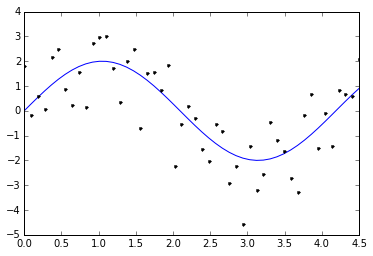

In [16]:
#Funciones para generar datos

def genFuntion( size ):    
    x = np.linspace( 0, 4.5, size )
    y = 2*np.sin( x*1.5 )
    return (x,y)

def genSample( size ):
    x = np.linspace( 0, 4.5, size )
    y = 2*np.sin( x*1.5 )+pl.randn( x.size )
    return (x,y)

size = 50
pl.clf()
f_x, f_y = genFuntion( size )
pl.plot( f_x, f_y )
x, y = genSample( size )
pl.plot(x, y, 'k.')

In [17]:
#Se adapta las funciones anteriores para aplicarlas al modelo creado
def function2( x, x2 ):
    return 2*np.sin( x*1.5 )
def kfun():
    return function2;

#Se crea y entrena el modelo
nueva = KRR( kfun, alpha=0.001 )
XX = np.linspace( 0, 4.5, size )
YY = 2*np.sin( x*1.5 )
nueva.fit(XX, YY)

<__main__.KRR instance at 0x000000000D11BB08>

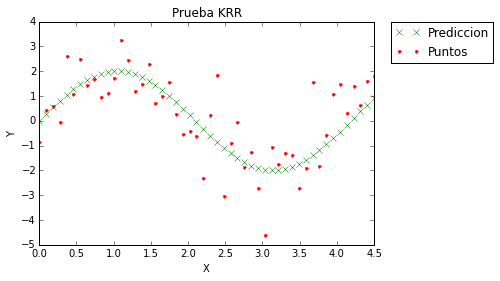

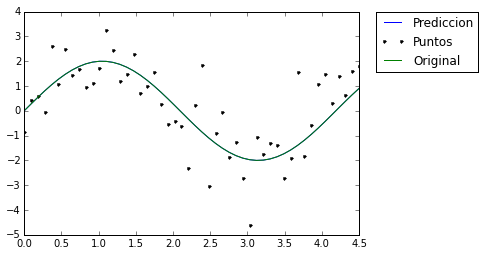

In [18]:
#Se generan nuevos datos y se usa el modelo para realizar la prediccion
auxSample = genSample( size )
pred = nueva.predict( f_x )

doPlot( pred, auxSample[1], ["Prediccion", "Puntos"], tieneX=1,ejeX=XX, ordenar=0, titulo="Prueba KRR")
pl.clf()
pl.plot( XX, pred, 'b-', label="Prediccion")
pl.plot(XX, auxSample[1], 'k.', label="Puntos")
pl.plot( XX, YY, 'g-', label="Original")
pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

###(c) Use the KRR implementation and the kernel k to train a model using the training data set

In [19]:
#Lectura de archivo de Entrenamiento
data = open( "Data/assign3-train.txt" )
lines = data.read().splitlines()
samples = [sample.split(" ") for sample in lines]
train = [ [sample[0], float(sample[1]) ] for sample in samples ]
print len(train), train[0:10], train[-10:]
#train = sorted(train, key=lambda tr: tr[1], reverse=True)
#print len(train), train[0:10], train[-10:]

100 [['CAAAGCCGG', -5.18906325187], ['TCATCCCTG', 4.28131606936], ['TGGCGTGCT', -0.301845302067], ['ACTGGGGGT', 3.70180552666], ['AAAGCATAG', 3.14257941172], ['TCTGCGCTG', 2.38908427031], ['TGTCGGATC', -2.27475563403], ['GGGTGTAGT', 11.9965070838], ['TACTTACCT', 10.6932370111], ['GTGTGTAAC', 17.2780782385]] [['CAAAAGCTA', -8.40289938286], ['ATTTGAAGC', 15.0439926937], ['AGCTACGAC', 13.813575869], ['CGCCTGCGA', -3.01635108622], ['CGAATTTGA', -7.41529147849], ['GACAATTAA', -1.42028504423], ['TGAGCGGTG', -2.28253395251], ['CAAAGGAAC', -0.297865952995], ['GTCTAGTGT', 8.46070369256], ['CGTTTTTAA', 17.0156355679]]


In [20]:
trainT = np.array(train).T
model = KRR( kernelStrings1 , alpha=0.1)
model.fit(trainT[0], map(float,trainT[1]) )
print model

<__main__.KRR instance at 0x000000000D2D2648>


In [21]:
pred = model.predict(trainT[0])
vals = map(float, trainT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]
display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

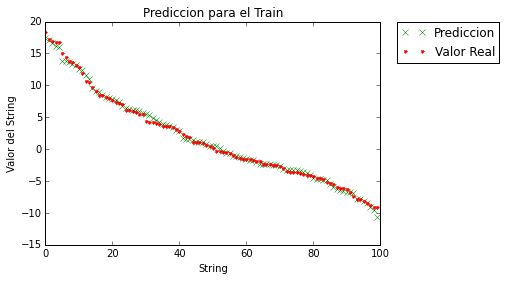

In [22]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Train")

###(d) Evaluate the trained model on the test data set

In [23]:
#Lectura de archivo de Test
data = open( "Data/assign3-test.txt" )
lines = data.read().splitlines()
samples = [sample.split(" ") for sample in lines]
test = [ [sample[0], float(sample[1]) ] for sample in samples ]
print len(test), test[:10], test[-10:]

50 [['GCTCCTAAT', 4.19273502554], ['CGTTGCCAT', 18.7690763817], ['GCCGTTCCT', 3.88305315574], ['GTCACTTGC', -7.06261561113], ['ATGTTTCGC', 11.2989859292], ['ACATATTCA', 7.27588038698], ['GTCTATGAG', 14.0355784595], ['GTCTGAAGT', 10.6277237323], ['CACACTACA', -2.88462311742], ['ATTTCACTG', 11.9747557709]] [['AGTTGACGC', 13.7349935357], ['GGTCGTGTC', -4.41285301185], ['TTTTGCTGA', 12.8972544772], ['TGAAGCTTC', -9.55596489916], ['CAGAGAGTA', -7.88802538885], ['CGAAGTAGT', -4.70641347], ['TACGTTTTG', -2.60943519735], ['TCAAGAGCA', -3.04374654509], ['CGGCCCTCG', -0.433408806264], ['GGCTGACCA', 11.5845831453]]


In [24]:
testT = np.array(test).T
pred = model.predict(testT[0])
vals = map(float, testT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]

display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

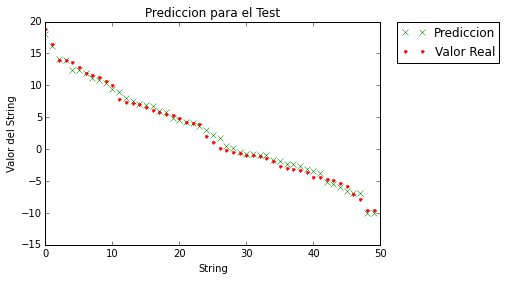

In [25]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Test")

###(e) Build a new kernel, $k'$, composing the kernel k with more complex kernel (polynomial, Gaussian, etc). Repeat steps (b) and (c). For instance, the new kernel may be defined as:
>$k'(x, y) = (k(x, y) + 1)^d$

where d is positive integer exponent.

In [26]:
#definir nueva funcion y kernel
def coincidences2( str1, str2):
    return (coincidences(str1, str2)+1)**3
def kernelStrings2():
    return coincidences2

In [27]:
#definir nueva funcion y kernel
def gaussian( str1, str2):
    from scipy.spatial.distance import pdist, squareform
    sigma2 = 10**2;
    vals = 0
    for idx in xrange( len(str1) ):
        vals += abs( ord(str1[idx] )-ord(str2[idx])-2*ord('A') )
    return vals**2/sigma2
def kernelStrings3():
    return gaussian

In [28]:
model2 = KRR( kernelStrings2 , alpha=0.1)
model2.fit( trainT[0], map(float, trainT[1]) )

<__main__.KRR instance at 0x0000000017D24088>

###(e)->(c)

In [29]:
pred = model2.predict(trainT[0])
vals = map(float, trainT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]
display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

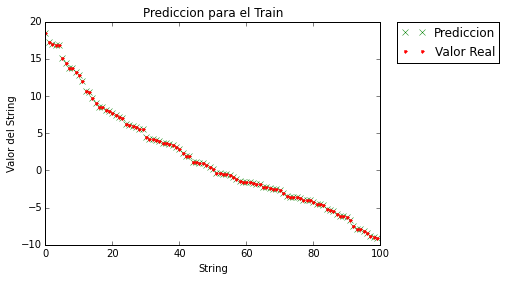

In [30]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Train")

###(e)->(d)

In [31]:
pred = model2.predict(testT[0])
vals = map(float, testT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]
display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

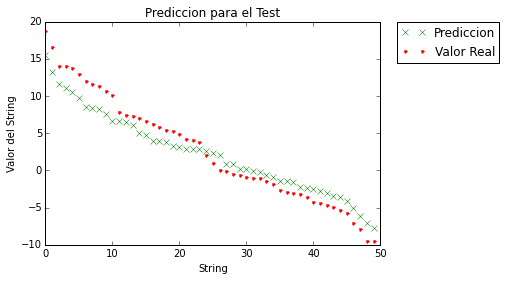

In [32]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Test")

##Punto 3

###A - Get the data from the Digit Recognizer problem

In [34]:
def showData( arch ):
    data =pd.read_csv( arch )
    print data
    return data['label']

labels = showData( "Data/train.csv" )

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
5          0       0       0       0       0       0       0       0       0   
6          7       0       0       0       0       0       0       0       0   
7          3       0       0       0       0       0       0       0       0   
8          5       0       0       0       0       0       0       0       0   
9          3       0       0       0       0       0       0       0       0   
10         8       0       0       0       0       0       0       0       0   
11         9       0       0       0    

In [35]:
def readData( arch , cabecera=0):
    data = open( arch )
    lines = data.read().splitlines()
    idx = 0
    if cabecera!=0:
        idx = 1
    #return lines
    imagenes = np.array([ [ int(val) for val in line.split(",")]  for line in lines[idx:] ])
    return imagenes

In [36]:
imagenes = readData( "Data/train.csv" , cabecera=1)
#print np.array(imagenes[1])

In [37]:
#Pasa el arreglo de 784 a una matriz de 28x28
def toImage( arr, label=0, nRows=28):
    if( label!=0 ):
        arr = arr[1:]
    n = len(arr)
    image = [[]]*nRows
    for idx in xrange(nRows):
        image[idx] = arr[idx*nRows:(idx+1)*nRows] 
    return np.array(image)

#Imprime la matriz y llama a ToImage
def printImage( arrayImage, label=1, nRows=28, rgb=1):
    image = toImage( arrayImage, label=label )
    titulos = ["Grafica", "Imagen de "+str(arrayImage[0])]
    title = titulos[label]
    pl.clf()
    pl.title( title )
    if rgb==1:
        cmap= pl.get_cmap('gray_r') 
        pl.imshow( image, cmap)
    else:
        pl.imshow( image )
    pl.show()

In [38]:
nClases = 10
claseImagen = [ [] for idx in xrange(nClases) ]
claseImagenL = [ [] for idx in xrange(nClases) ]

for imagen in imagenes:
    claseImagen[ imagen[0] ].append( imagen[1:] )
    claseImagenL[ imagen[0] ].append( imagen )


print "IDX\tTam Comjunto"
for idx in xrange( nClases ):
    print "{0}\t   {1}".format(idx, len(claseImagen[idx]) )

IDX	Tam Comjunto
0	   4132
1	   4684
2	   4177
3	   4351
4	   4072
5	   3795
6	   4137
7	   4401
8	   4063
9	   4188


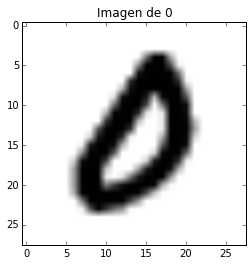

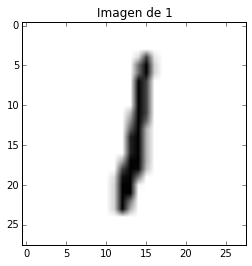

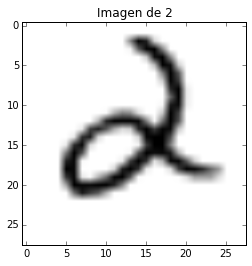

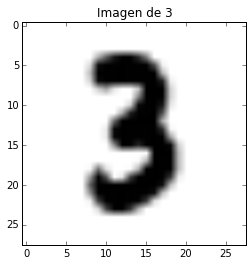

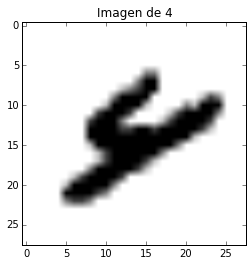

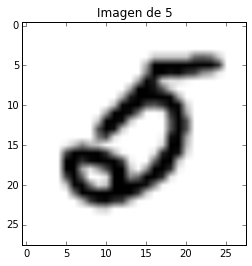

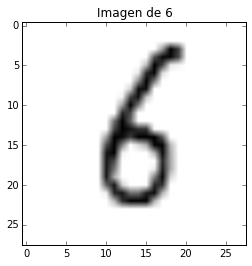

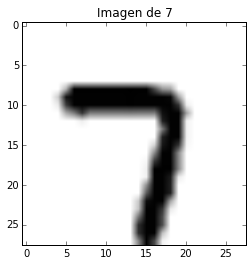

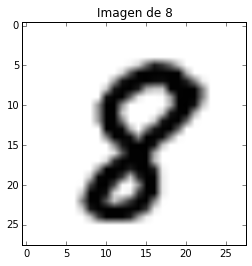

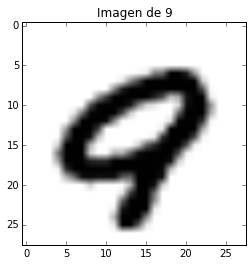

In [39]:
for idx in xrange( nClases ):
    printImage( claseImagenL[idx][-42] )

In [40]:
nuevoConjunto = imagenes#claseImagenL[5]+claseImagenL[3]
trainP3, testP3 = skl.cross_validation.train_test_split(nuevoConjunto, test_size=0.5)
print "Tamano Train {0}, Tamano Test {1}".format( len(trainP3), len(testP3) )


Tamano Train 21000, Tamano Test 21000


In [41]:
display(Math(r'Train'))
print np.array(trainP3[:5])
display(Math(r'Test'))
print np.array(testP3[:5])

<IPython.core.display.Math object>

[[2 0 0 ..., 0 0 0]
 [9 0 0 ..., 0 0 0]
 [7 0 0 ..., 0 0 0]
 [3 0 0 ..., 0 0 0]
 [7 0 0 ..., 0 0 0]]


<IPython.core.display.Math object>

[[2 0 0 ..., 0 0 0]
 [6 0 0 ..., 0 0 0]
 [4 0 0 ..., 0 0 0]
 [5 0 0 ..., 0 0 0]
 [6 0 0 ..., 0 0 0]]


In [42]:
labelP3, dataP3 = separarDatos( trainP3 )
clf = svm.LinearSVC( C=100 )
clf.fit(dataP3, labelP3)

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [43]:
labelTest3, dataTest3 = separarDatos( testP3 );
sol = clf.predict( dataTest3 )

In [44]:
#Revisa los que estan mal clasificados
dif = [ idx for idx in xrange( len(sol) ) if labelTest3[idx]!=sol[idx] ]

In [45]:
print len(dif), len(labelTest3)

2745 21000


Missmatch 3  Correct 9


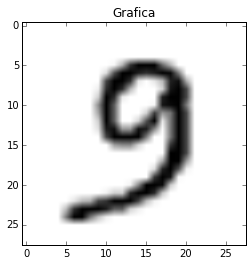

Missmatch 9  Correct 7


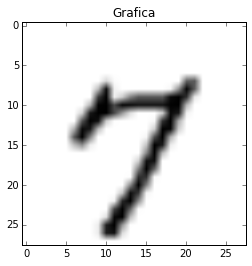

Missmatch 3  Correct 8


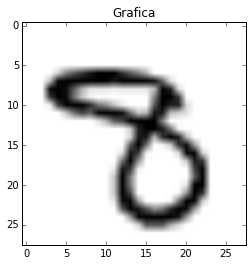

Missmatch 8  Correct 9


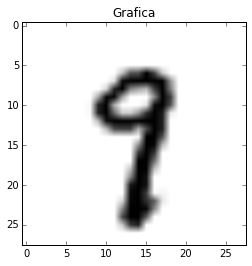

Missmatch 5  Correct 9


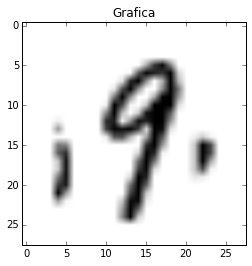

Missmatch 9  Correct 7


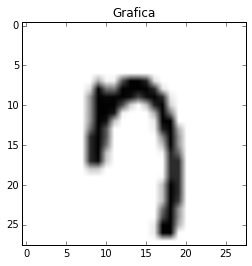

Missmatch 3  Correct 8


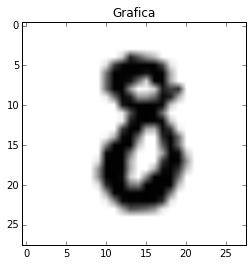

Missmatch 8  Correct 2


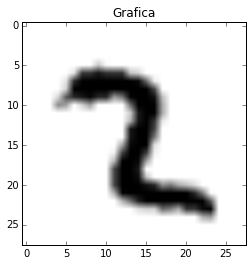

Missmatch 5  Correct 8


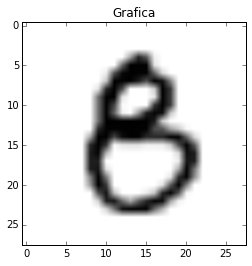

Missmatch 5  Correct 3


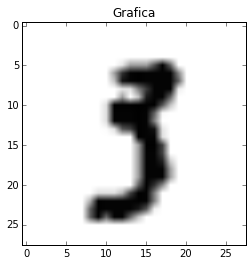

In [46]:
for miss in dif[:10]:
    print "Missmatch", sol[miss], " Correct", labelTest3[miss]
    printImage( dataTest3[miss] ,label=0)


###B - Choose two classes

In [47]:
def clasificarDatos( pc, typeData =0 , imprimirError=1):
    global imagenes, trainP3, testP3
    clf = svm.LinearSVC( C=pc )
    
    if typeData==0 :
        test = trainP3
    else:
        test = testP3
    
    label, data = separarDatos( trainP3 )
    clf.fit(data, label)
    
    labelTest, dataTest = separarDatos( test );
    sol = clf.predict( dataTest )
    
    dif = [ idx for idx in xrange( len(sol) ) if labelTest[idx]!=sol[idx] ]
    
    if imprimirError==1:
        display( Math(r"\% Error "+str(pc)+": {:.2%}".format( len(dif)*1.0/len( labelTest ) )  ) )
    
    error = calcularError( sol, labelTest )
    return error
    

Se eliguen para comparar las clases 5 y 3, se separan los datos en Training y Test con el 60% y 40% de los datos respectivamente.

In [48]:
#Se eligen 2 clases y almancenan los datos en "nuevoConjunto"
nuevoConjunto = claseImagenL[5]+claseImagenL[3]
trainP3, testP3 = skl.cross_validation.train_test_split(nuevoConjunto, test_size=0.4)
print "Tamano Train {0}, Tamano Test {1}".format( len(trainP3), len(testP3) )

Tamano Train 4887, Tamano Test 3259


In [49]:
cs = []
error = []

for pot in xrange( -5, 16 ):
    cs.append( 2**pot )
    error.append( clasificarDatos( 2**pot ) )
    
cs = np.array( cs )
error = np.array( error )

tabla = zip( cs.T, error.T )

pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,2.000000,4.000000,8.000000,16.000000,...,64.000000,128.000000,256.000000,512.000000,1024.000000,2048.000000,4096.000000,8192.000000,16384.000000,32768.000000
$Error$,0.013096,0.022918,0.011459,0.013914,0.022918,0.017188,0.015551,0.004911,0.009003,0.009003,...,0.015551,0.018825,0.022099,0.013096,0.034377,0.004911,0.011459,0.041743,0.021281,0.011459


In [50]:

errorTest = []

for pot in xrange( -5, 16 ):
    
    errorTest.append( clasificarDatos( 2.0**pot, typeData=1) )
    
errorTest = np.array( errorTest )

tabla = zip( cs.T, errorTest.T )
display()
pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,2.000000,4.000000,8.0000,16.000000,...,64.000000,128.000000,256.000000,512.000000,1024.000000,2048.00000,4096.000000,8192.00000,16384.00000,32768.00000
$Error$,0.245474,0.240565,0.245474,0.235655,0.247929,0.244247,0.243019,0.252838,0.2332,0.235655,...,0.244247,0.243019,0.250384,0.244247,0.239337,0.23811,0.229518,0.26143,0.23811,0.23811


Se hace la clasificacion de las imagenes y se muestra el error(suma del error en traning y en el test) y el parametro C

In [51]:
sumError = error+errorTest;
tabla = zip(cs.T, sumError.T)
pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16))

,$C$,$Error$
-5,0.03125,0.258570
-4,0.06250,0.263483
-3,0.12500,0.256933
-2,0.25000,0.249570
-1,0.50000,0.270847
0,1.00000,0.261435
1,2.00000,0.258571
2,4.00000,0.257749
3,8.00000,0.242204
4,16.00000,0.244659


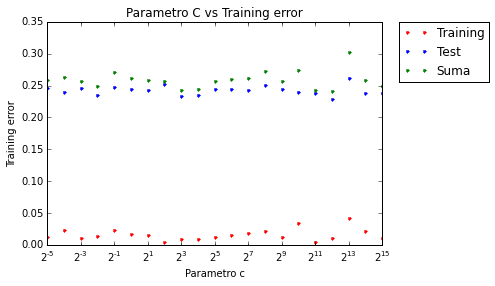

In [52]:
pl.clf()
titulo = str("Parametro C vs Training error")
labelX ="Parametro c"
labelY = "Training error"
pl.title( titulo )
pl.plot(cs,error, 'r.', label="Training")
pl.plot(cs,errorTest, 'b.', label="Test")
pl.plot(cs,sumError, 'g.', label="Suma")
pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
pl.xscale('log', basex=2)
pl.xlabel( labelX )
pl.ylabel( labelY )


En la gráfica se muestra el error en el entrenamiento, el error en la predicción y la suma de ambos errores para los diferentes valores del parametro C

A continuación se obtiene el parámetro óptimo C

In [53]:
best = np.argmin( sumError )
display( Math(r'El mejor:'+str(best)) )
display( Math(r'C: 2\^'+str(best-5) ) )
display( Math(r'C:'+str(cs[best]) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Los mejores resultados se encuentran en los valor de C más altos ($2^{12}$ y $2^{15}$), pero en la gráfica se ve que para el valor de C mas bajo tambien tuvo buenos resultados, esto se puede deber a que hay varios puntos en la frontera los cuales son bien clasificados con los límites calculados extremos de la misma. Como se ve en el gráfico de colores, son pocos los pixeles muy significativos en la mayoría de los casos, esto crea muchos puntos que se pueden mover alrededor de las fronteras(debido a pixeles poco significativos). 

###C - Extract the weights of the classification model found in (b).

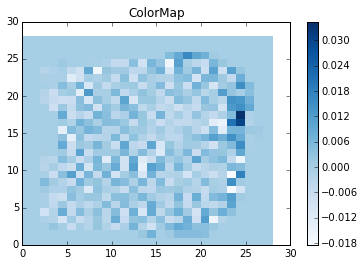

In [54]:
clf = svm.LinearSVC( C=cs[best] )
label, data = separarDatos( trainP3 )
clf.fit(data, label)

weights = clf.coef_.reshape( (28,28) )
pl.title("ColorMap")
pl.pcolor( weights[::-1], cmap='Blues', vmin=np.min(weights), vmax=np.max(weights) )
pl.colorbar()
pl.show()

###D - Plot de discriminant

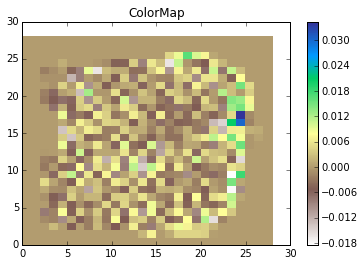

In [55]:
pl.title("ColorMap")
pl.pcolor( weights[::-1], cmap='terrain_r', vmin=np.min(weights), vmax=np.max(weights) )
pl.colorbar()
pl.show()

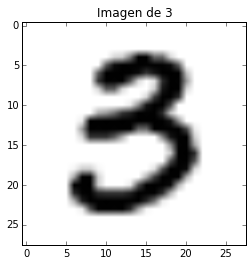

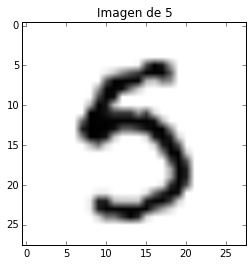

In [56]:
printImage( claseImagenL[3][1069] )
printImage( claseImagenL[5][1069] )

####Discusión de resultados

En el caso del 3 y el 5, el pixel más importante para discriminar el número tres es el la interesseción de las curvas del tres, siendo las curvas del tres los siguientes pixeles más importantes. Para discriminar el número 5 los pixeles más importantes son la línea perpendicular que une el inicio del número y el trazo circular de la parte inferior. Estos pixeles no son tan importantes porque se puede dar el caso de un tres que tenga pixeles en ese lugar. Además se ve una tendencia del número 5 a tener mas pixeles localizados en el lado izquierdo de la gráfica.

###Extra

Se crea una funcion que realize los pasos anteriores, pero dando la posibilidad de elegir las clases a comparar

In [57]:
def doPunto3( idx1, idx2, porcentajeTest=0.4 , impError=0):
    global claseImagenL, trainP3, testP3
    print "Se analizara para los conjuntos del {} y el {}".format(idx1, idx2)
    #Se eligen 2 clases y almancenan los datos en "nuevoConjunto"
    nuevoConjunto = claseImagenL[idx1]+claseImagenL[idx2]
    trainP3, testP3 = skl.cross_validation.train_test_split(nuevoConjunto, test_size=porcentajeTest)
    print "Tamano Train {0}, Tamano Test {1}".format( len(trainP3), len(testP3) )
    
    #Se calculan el Error para el conjunto de entrenamiento
    cs = []
    error = []
    for pot in xrange( -5, 16 ):
        cs.append( 2**pot )
        error.append( clasificarDatos( 2.0**pot , imprimirError=impError) )
    cs = np.array( cs )
    error = np.array( error )
    
    #Se imprime los resultados para el conjunto de entrenamiento
    tabla = zip( cs.T, error.T )
    display( Math("Error Train") )
    #print pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T
    display( pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T )
    
    #Se calculan el Error para el conjunto de Prueba
    errorTest = []
    for pot in xrange( -5, 16 ):
        errorTest.append( clasificarDatos( 2.0**pot, typeData=1, imprimirError=impError) )
    
    errorTest = np.array( errorTest )
    #Se imprime los resultados para el conjunto de Prueba
    tabla = zip( cs.T, errorTest.T )
    display( Math("Error Test") )
    display( pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T )
    
    #Se calcula e imprime los resultados del error en los 2 conjuntos
    sumError = error+errorTest;
    tabla = zip(cs.T, sumError.T)
    display( Math("Error Total") )
    display( pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T )
    
    print "\n\n\n"
    #Graficando el error vs el parametro C de regularizacion
    pl.clf()
    titulo = str("Parametro C vs Training error")
    labelX ="Parametro c"
    labelY = "Training error"
    pl.title( titulo )
    pl.plot(cs,error, 'r.', label="Training")
    pl.plot(cs,errorTest, 'b.', label="Test")
    pl.plot(cs,sumError, 'g.', label="Suma")
    pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    pl.xscale('log', basex=2)
    pl.xlabel( labelX )
    pl.ylabel( labelY )
    pl.show()
    
    #Se encuentra el parametro optimo C de regularizacion
    best = np.argmin( sumError )
    display( Math(r'El mejor:'+str(best)) )
    display( Math('C: 2^'+str(best-5) ) )
    display( Math(r'C:'+str(cs[best]) ) )
    
    #Se entrena el modelos Lineal de SVM
    clf = svm.LinearSVC( C=cs[best] )
    label, data = separarDatos( trainP3 )
    clf.fit(data, label)

    #Se  extraen los peso del modelo de clasificacion
    weights = clf.coef_

    #Graficar la funcion discriminante
    weights = weights.reshape( (28,28) )
    pl.clf()
    pl.title("Color Map")
    pl.pcolor( weights[::-1], cmap='rainbow', vmin=np.min(weights), vmax=np.max(weights) )
    pl.colorbar()
    pl.show()

Se analizara para los conjuntos del 3 y el 0
Tamano Train 5089, Tamano Test 3394


<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.03125,0.0625,0.125,0.25,0.5,1,2,4,8,16,...,64,128,256,512,1024,2048,4096,8192,16384,32768
$Error$,0.00000,0.0000,0.000,0.00,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,2.000000,4.000000,8.000000,16.000000,...,64.000000,128.000000,256.000000,512.000000,1024.000000,2048.000000,4096.000000,8192.000000,16384.000000,32768.000000
$Error$,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,...,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687


<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,2.000000,4.000000,8.000000,16.000000,...,64.000000,128.000000,256.000000,512.000000,1024.000000,2048.000000,4096.000000,8192.000000,16384.000000,32768.000000
$Error$,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,...,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687,0.055687


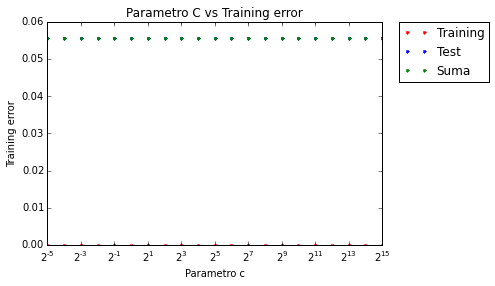

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

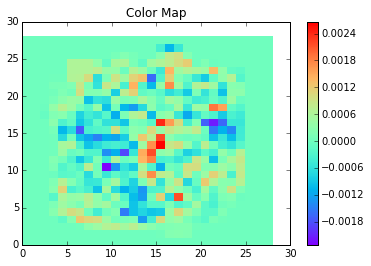

In [58]:
idx1 = 3
idx2 = 0
doPunto3( idx1, idx2)

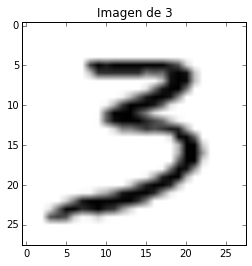

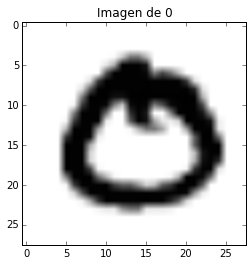

In [59]:
printImage( claseImagenL[idx1][4] )
printImage( claseImagenL[idx2][4] )

####Discusión de resultados

En el caso del 3 y 0, se encuentra una acumulación de pixeles importantes en el centro, ya que el 0 no tiene pixeles en esa área, así mismo se ven pixeles importantes en los bordes de la gráfica sobre todo en el lado izquierdo, lugar donde el número tres no tiene trazos.

### E - Envío a KAGGLE

Se envia la prediccion de las 10 clases utilizando un SVM Lineal

In [ ]:
totalTrain = imagenes
testData = readData( "Data/test.csv", cabecera=1)

In [ ]:
labelP3, dataP3 = separarDatos( totalTrain )
clf = svm.LinearSVC( C=100 )
clf.fit(dataP3, labelP3)

In [ ]:
sol = clf.predict( testData )

In [ ]:
for idx in xrange( 10 ):
    print "Prediccion", sol[idx]
    printImage( testData[idx] , label=0)

In [ ]:
#salida = [[index + 1, x] for index, x in enumerate(sol)]
salida = zip( range(1, len(sol)+1 ) , sol )

In [ ]:
np.savetxt('Data/submission.csv', salida, delimiter=',', fmt='%d,%d', header='ImageId,Label')

In [5]:
%%cmd
type Data\submission.csv

Microsoft Windows [Versi�n 6.1.7601]
Copyright (c) 2009 Microsoft Corporation. Reservados todos los derechos.

C:\Users\Lin\Documents\GitHub\MachineLearning\Taller 3>type Data\submission.csv
# ImageId,Label
1,2
2,0
3,9
4,7
5,2
6,7
7,0
8,3
9,0
10,3
11,5
12,7
13,4
14,0
15,4
16,0
17,3
18,1
19,9
20,0
21,9
22,1
23,1
24,5
25,7
26,4
27,2
28,7
29,7
30,7
31,7
32,5
33,4
34,2
35,6
36,2
37,9
38,5
39,1
40,6
41,7
42,7
43,4
44,9
45,8
46,7
47,8
48,8
49,6
50,1
51,6
52,8
53,8
54,3
55,8
56,2
57,1
58,2
59,1
60,0
61,4
62,1
63,7
64,0
65,0
66,0
67,1
68,9
69,0
70,1
71,6
72,5
73,8
74,8
75,2
76,8
77,2
78,9
79,2
80,2
81,5
82,9
83,1
84,0
85,9
86,2
87,4
88,3
89,6
90,7
91,2
92,0
93,6
94,6
95,8
96,4
97,3
98,9
99,7
100,7
101,0
102,8
103,2
104,0
105,7
106,3
107,0
108,5
109,0
110,3
111,0
112,0
113,4
114,7
115,1
116,7
117,1
118,1
119,5
120,2
121,3
122,7
123,2
124,8
125,6
126,3
127,8
128,7
129,8
130,4
131,3
132,5
133,6
134,0
135,0
136,0
137,3
138,1
139,5
140,0
141,4
142,3
143,4
144,5
145,5
146,8
147,7
148,7
149,2
150,8
1

Los resultados pueden verificarse <a href="https://www.kaggle.com/jfcowboy/results">Aca</a>


<img src="Data/Resultado1Kaggle.PNG">

##Punto 4

###A  - Build training and test data sets

In [6]:
def buildDictionary( fromFile, toFile ):
    data = open( fromFile )
    lines = data.read().splitlines()
    arch = []
    for line in lines:
        words = line.split()
        for word in words:
            if len(word)<=4 or (word[0]>='0' and word[0]<='9'):
                continue
            arch.append(word)
    np.savetxt(toFile, arch, fmt='%s')

In [ ]:
buildDictionary("Data/prevDataEs.txt", "Data/dataEs.txt")
buildDictionary("Data/prevDataEn.txt", "Data/dataEn.txt")

In [7]:
%%cmd
type Data\dataEn.txt
type Data\dataEs.txt

Microsoft Windows [Versi�n 6.1.7601]
Copyright (c) 2009 Microsoft Corporation. Reservados todos los derechos.

C:\Users\Lin\Documents\GitHub\MachineLearning\Taller 3>type Data\dataEn.txt
which
their
would
there
could
other
about
little
should
great
before
these
after
first
never
shall
where
those
himself
without
through
being
might
again
think
every
people
thought
under
found
still
place
while
young
though
against
things
years
nothing
right
another
house
world
three
always
night
between
heart
because
thing
seemed
looked
called
whole
heard
country
asked
going
better
having
something
moment
father
among
course
hands
woman
enough
words
mother
almost
small
cannot
water
however
light
quite
brought
whose
given
turned
taken
morning
myself
Gutenberg
until
since
power
themselves
rather
began
present
voice
others
white
works
money
death
stood
within
together
large
matter
often
certain
herself
friend
order
round
anything
means
believe
passed
public
state
hundred
children
alone
above
person
alread

Se extraen los datos y se crea un nuevo Dataset el cual contiene 8800 palabras para español y 8430 palabras para inglés.

In [8]:
accents = {'á' : 'a', 'Á' : 'a',
         'é' : 'e', 'É' : 'e',
         'í' : 'i', 'Í' : 'i',
         'ó' : 'o', 'Ó' : 'o',
         'ú' : 'u', 'Ú' : 'u',
         'ñ' : 'n', 'Ñ' : 'n',
         'ü' : 'u', 'Ü' : 'u',
         "'" : ''}
dataEs = open("Data/dataEs.txt")
lines = dataEs.read().splitlines()

palabrasEs = []
for line in lines:
    for a in accents:
        line = line.replace(a,accents[a])  
    line = line.lower()
    palabrasEs.append([1,line])

print palabrasEs

[[1, 'esta'], [1, 'aqui'], [1, 'vamos'], [1, 'ahora'], [1, 'estoy'], [1, 'tengo'], [1, 'cuando'], [1, 'estas'], [1, 'puedo'], [1, 'como'], [1, 'quiero'], [1, 'solo'], [1, 'tiene'], [1, 'gracias'], [1, 'bueno'], [1, 'hacer'], [1, 'todos'], [1, 'tienes'], [1, 'puede'], [1, 'sabes'], [1, 'porque'], [1, 'quien'], [1, 'nunca'], [1, 'donde'], [1, 'quieres'], [1, 'favor'], [1, 'senor'], [1, 'tiempo'], [1, 'verdad'], [1, 'estaba'], [1, 'mejor'], [1, 'estan'], [1, 'hombre'], [1, 'usted'], [1, 'mucho'], [1, 'entonces'], [1, 'siento'], [1, 'tenemos'], [1, 'puedes'], [1, 'alguien'], [1, 'hasta'], [1, 'anos'], [1, 'sobre'], [1, 'decir'], [1, 'siempre'], [1, 'cosas'], [1, 'tambien'], [1, 'antes'], [1, 'estar'], [1, 'estamos'], [1, 'noche'], [1, 'nadie'], [1, 'quiere'], [1, 'parece'], [1, 'nosotros'], [1, 'padre'], [1, 'trabajo'], [1, 'gente'], [1, 'donde'], [1, 'mismo'], [1, 'hecho'], [1, 'ellos'], [1, 'dinero'], [1, 'hablar'], [1, 'seguro'], [1, 'claro'], [1, 'estas'], [1, 'lugar'], [1, 'mundo'], [

In [9]:
dataEn = open("Data/dataEn.txt")
lines = dataEn.read().splitlines()

palabrasEn = []
for line in lines:
    line = line.replace("-","")
    palabrasEn.append([0,line.lower()])

print palabrasEn
    

[[0, 'which'], [0, 'their'], [0, 'would'], [0, 'there'], [0, 'could'], [0, 'other'], [0, 'about'], [0, 'little'], [0, 'should'], [0, 'great'], [0, 'before'], [0, 'these'], [0, 'after'], [0, 'first'], [0, 'never'], [0, 'shall'], [0, 'where'], [0, 'those'], [0, 'himself'], [0, 'without'], [0, 'through'], [0, 'being'], [0, 'might'], [0, 'again'], [0, 'think'], [0, 'every'], [0, 'people'], [0, 'thought'], [0, 'under'], [0, 'found'], [0, 'still'], [0, 'place'], [0, 'while'], [0, 'young'], [0, 'though'], [0, 'against'], [0, 'things'], [0, 'years'], [0, 'nothing'], [0, 'right'], [0, 'another'], [0, 'house'], [0, 'world'], [0, 'three'], [0, 'always'], [0, 'night'], [0, 'between'], [0, 'heart'], [0, 'because'], [0, 'thing'], [0, 'seemed'], [0, 'looked'], [0, 'called'], [0, 'whole'], [0, 'heard'], [0, 'country'], [0, 'asked'], [0, 'going'], [0, 'better'], [0, 'having'], [0, 'something'], [0, 'moment'], [0, 'father'], [0, 'among'], [0, 'course'], [0, 'hands'], [0, 'woman'], [0, 'enough'], [0, 'wo

In [10]:
TAMTrain = 1000
TAMTest = 100
palabras = palabrasEn + palabrasEs
trainWords, testWords = skl.cross_validation.train_test_split(palabras, test_size=0.40)
trainWords = trainWords[:TAMTrain]
testWords = testWords[:TAMTest]
trainWords = np.array( trainWords )
testWords = np.array( testWords )
print "Tamano Train {0}, Tamano Test {1}".format( len(trainWords), len(testWords) )


Tamano Train 1000, Tamano Test 100


###B - Program a string kernel

Se crean dos Kernels:
>KernelWords1: Tiene en cuenta la posicion de las letras para calcular la similitud entre las palabras

>KernelWords2: Tiene en cuenta la simulitud en la frecuencia de las letras entre las palabras para calcular que tan parecidas son las palabras

In [43]:
#Funcion de kernel que cuenta conincidencias de letras por posicion

def kernelWords1(word1, word2):
    cnt = 0
    minTam = min(len(word1),len(word2))
    for k in xrange(minTam):
        if(word1[k] == word2[k]):
            cnt = cnt + 1
    return cnt

def kernelWords2(word1, word2):
    cnt = 0.0
    vec1 = np.zeros(27)
    vec2 = np.zeros(27)
    for w in word1:
        #print w, "-", word1, word2
        if w >= 'a' and w <='z':
            vec1[ord(w) - ord('a')] += 1
    for w in word2:
        if w >= 'a' and w <='z':
            vec2[ord(w) - ord('a')] += 1
    for k in xrange(27):
        cnt += min(vec1[k] , vec2[k])
    return cnt

###C - Train a SVM using precomputed kernel

SE crea una funcion para obtener la matriz de Kernel

In [12]:
KK = []
def getKernel( X , kernel):
    global KK
#     print self, X, self.kernel
    KK = []
    for x in X:
        row = []
        for y in X:
            res = kernel(x, y)
            row.append( res )
        KK.append(row)
        
    return np.array(KK)

A continuacion se van a hacer las pruebas necesarias para crear el kernel, entrenar la SVM y hacer las predicciones

In [ ]:
#X
precompKernel = getKernel(trainWords,kernelWords1)
print precompKernel

In [ ]:
#Liberar memoria 
KK = None
palabras = None
print len(precompKernel[1])

In [ ]:
#Matriz gram con X
gram = np.dot(precompKernel, precompKernel.T)

In [ ]:
#Entrenar el modeo con gram
clf = svm.SVC( kernel='precomputed' )
clf.fit( gram, map(int, trainWords.T[0]) )


In [ ]:
#Predecir Train 
#predictionTrain = clf.predict(gram) #predecir esto

In [ ]:
#Predecir Train 
predictionTrain = clf.predict(precompKernel) #predecir esto

In [ ]:
print predictionTrain[0:15]
print len(predictionTrain)
print trainWords.T[0][:15]

In [ ]:
aux = map(int,trainWords.T[0])
cont = []
for k in xrange(len(predictionTrain)):
    if(predictionTrain[k] != aux[k]):
        cont.append(k)
print len(cont)

In [13]:
#Prediccion para el test
def getMatTest( X, Y, kernel):
    KK = []
    for x in Y:
        row = []
        for y in X:
            res = kernel(x, y)
            row.append( res )
        KK.append(row)
        
    return np.array(KK)

In [14]:
#Aplicar el kernel para los del conjunto de prueba
precompTest = getMatTest(trainWords, testWords, kernelWords1)
#gram2 = np.dot(preCompTest, preCompTest.T ) #watt?

In [ ]:
#gram2 = np.dot(preCompTest, precompKernel.T )

In [ ]:
#print len(gram2[0])

In [ ]:
predictionTest = clf.predict(precompTest)
#predictionTestGram = clf.predict(gram2)

In [ ]:
print predictionTest[0:15]
print testWords.T[0][:15]

In [ ]:
aux = map(int,testWords.T[0])
cont2 = []
for k in xrange(len(predictionTest)):
    if(predictionTest[k] != aux[k]):
        cont2.append(k)
print len(cont2)

#### Utilizando el kernel 1

Ahora se va a calcular la matriz de Kernel y a predecir sobre los valores de Training y Test utilizando el KernelWords1

In [65]:
precompKernel = getKernel(trainWords.T[1],kernelWords1)

In [66]:
KK = None

In [67]:
gram = np.dot(precompKernel, precompKernel.T)

In [68]:
precompTest = getMatTest(trainWords.T[1], testWords.T[1], kernelWords1)

In [69]:
def predecir(train, test, kernel, C, gram, precompKernel, precompTest):
    
    #precompKernel = getKernel(train,kernel)
    
    #gram = np.dot(precompKernel, precompKernel.T)
    clf = svm.SVC( kernel='precomputed', C = C )
    clf.fit( gram, map(int, train.T[0]) )
    
    predictionTrain = clf.predict(precompKernel)
    aux = map(int,trainWords.T[0])
    cont = []
    for k in xrange(len(predictionTrain)):
        if(predictionTrain[k] != aux[k]):
            cont.append(k)
    
    #preCompTest = getMatTest(train, test, kernel)
    predictionTest = clf.predict(precompTest)
    aux = map(int,testWords.T[0])
    cont2 = []
    for k in xrange(len(predictionTest)):
        if(predictionTest[k] != aux[k]):
            cont2.append(k)
    return cont, cont2

In [ ]:
cont, cont2 = predecir(trainWords, testWords, kernelWords1, 0.001, gram, precompKernel, preCompTest)

#### Utilizando el kernel 2

Ahora se va a calcular la matriz de Kernel y a predecir sobre los valores de Training y Test utilizando el KernelWords2

In [44]:
precompKernel2 = getKernel(trainWords.T[1],kernelWords2)

In [45]:
KK = None

In [46]:
gram2 = np.dot(precompKernel2, precompKernel2.T)

In [48]:
precompTest2 = getMatTest(trainWords.T[1], testWords.T[1], kernelWords2)

###D - Use cross validation to find an appropriate regularization parameter

####Usando el primer Kernel

In [70]:
values = []
for k in xrange(-5,4):
    cont, cont2 = predecir(trainWords, testWords, kernelWords1, 2**k, gram, precompKernel, precompTest)
    values.append([cont,cont2])
    print k,len(cont),len(cont2)

-5 502 54
-4 502 54
-3 502 54
-2 496 54
-1 291 40
0 288 37
1 483 44
2 479 42
3 475 42


In [71]:
errores1  = []
for k in values:
    errores1.append(len(k[0]) + len(k[1]))
print errores1 

[556, 556, 556, 550, 331, 325, 527, 521, 517]


In [72]:
minArg1 = np.argmin(errores1)
print errores1[minArg1]

325


Palabras mal clasficadas, se muestra el idioma de clasificación original y la palabra.

In [73]:
miss1 = values[minArg1]
display(Math("Palabras mal clasificadas"))
for k in miss1[1]:
    print k, testWords[k]

<IPython.core.display.Math object>

2 ['0' 'accomplished']
3 ['0' 'arched']
4 ['0' 'rainbow']
5 ['1' 'adivinar']
8 ['0' 'efforts']
14 ['0' 'apparent']
16 ['0' 'gloucester']
17 ['0' 'quitted']
19 ['1' 'espada']
24 ['0' 'ralph']
27 ['1' 'entren']
32 ['1' 'estuvieran']
33 ['1' 'forma']
43 ['1' 'whisky']
44 ['0' 'reverence']
45 ['0' 'guest']
46 ['0' 'paths']
47 ['1' 'semanas']
48 ['1' 'claras']
54 ['1' 'filmar']
57 ['1' 'cometa']
58 ['1' 'nombres']
63 ['0' 'egyptian']
66 ['0' 'material']
68 ['0' 'double']
70 ['0' 'comfortably']
74 ['1' 'blake']
76 ['1' 'madura']
77 ['0' 'pilgrimage']
80 ['0' 'state']
83 ['1' 'egoista']
87 ['0' 'outbreak']
88 ['0' 'joyful']
90 ['0' 'honor']
92 ['1' 'eddie']
95 ['1' 'vosotras']
98 ['0' 'arrival']


El primer tenia en cuenta las posiciones de las letras en la palabra, pero este no es una buena comparación a nivel del lenguaje ya que pueden haber palabras que tengan prefijos o sufijos parecidos las cuales van a pesar a la hora de la clasificación. Además pueden haber raices similares o incluso silabas en la palabra que hagan que la clasificación no sea la adecuada.

#### Usando el segundo Kernel

In [49]:
values2 = []
for k in xrange(-5,4):
    cont, cont2 = predecir(trainWords, testWords, kernelWords2, 2**k, gram, precompKernel2, precompTest2)
    values.append([cont,cont2])
    print k,len(cont),len(cont2)

-5 502 54
-4 494 54
-3 448 46
-2 457 53
-1 475 52
0 472 56
1 484 50
2 482 50
3 478 51


In [56]:
errores2  = []
for k in values:
    errores2.append(len(k[0]) + len(k[1]))
print errores2

[556, 556, 556, 550, 331, 325, 527, 521, 517, 556, 548, 494, 510, 527, 528, 534, 532, 529]


In [57]:
minArg2 = np.argmin(errores2)
print errores1[minArg2]

325


In [58]:
miss2 = values[10]
for k in miss2[1]:
    print k, testWords[k]

0 ['1' 'estreno']
1 ['1' 'nobles']
5 ['1' 'adivinar']
6 ['1' 'suicido']
11 ['1' 'encontrarte']
13 ['1' 'danado']
18 ['1' 'lavanderia']
19 ['1' 'espada']
20 ['1' 'cuadras']
22 ['1' 'encontrara']
25 ['1' 'heroes']
26 ['1' 'condenados']
27 ['1' 'entren']
30 ['1' 'deberia']
31 ['1' 'falsas']
32 ['1' 'estuvieran']
33 ['1' 'forma']
36 ['1' 'punos']
37 ['1' 'dejala']
38 ['1' 'quedo']
39 ['1' 'basada']
40 ['1' 'enrique']
41 ['1' 'ejercicios']
42 ['1' 'diario']
43 ['1' 'whisky']
47 ['1' 'semanas']
48 ['1' 'claras']
49 ['1' 'pearl']
50 ['1' 'comunicado']
51 ['1' 'velma']
53 ['1' 'muerde']
54 ['1' 'filmar']
55 ['1' 'cerebros']
56 ['1' 'pulso']
57 ['1' 'cometa']
58 ['1' 'nombres']
60 ['1' 'davis']
62 ['1' 'pongase']
64 ['1' 'atravesar']
73 ['1' 'note']
74 ['1' 'blake']
75 ['1' 'sacerdote']
76 ['1' 'madura']
78 ['1' 'cuidando']
81 ['1' 'conmigo']
83 ['1' 'egoista']
85 ['1' 'entregado']
91 ['1' 'langosta']
92 ['1' 'eddie']
93 ['1' 'sonriendo']
94 ['1' 'matare']
95 ['1' 'vosotras']
96 ['1' 'tirando']

Para el segundo Kernel seria ideal incluir el peso de cada letra segun la frecuencia en el lenguaje.

### E - Confussion Matrix

####Usando el primer Kernel

In [74]:
badEn = 0
badEs = 0
for k in miss1[0]:
    if( trainWords[k][0] == '1'):
        badEn += 1
    else:
        badEs += 1

for k in miss1[1]:
    if( testWords[k][0] == '1'):
        badEn += 1
    else:
        badEs += 1


In [75]:
print badEn, badEs

125 200


In [76]:
en = 0
es = 0
for k in trainWords:
    if( k[0] == '1'):
        en += 1
    else:
        es += 1
for k in testWords:
    if( k[0] == '1'):
        en += 1
    else:
        es += 1

In [77]:
print en, es

556 544


In [78]:
wi = zip([en - badEn, es - badEs],[badEn,badEs])

pd.DataFrame(data=wi, columns=['$\mathbf{Goods}$', '$\mathbf{Bads}$'], index=['english', 'spanish'])

,$\mathbf{Goods}$,$\mathbf{Bads}$
english,431,125
spanish,344,200


Las palabras y la explicación se muestran antes del calculo de la matriz de confusión

#### Usando el segundo Kernel

In [62]:
badEn = 0
badEs = 0
for k in miss2[0]:
    if( trainWords[k][0] == '1'):
        badEn += 1
    else:
        badEs += 1

for k in miss2[1]:
    if( testWords[k][0] == '1'):
        badEn += 1
    else:
        badEs += 1


In [63]:
print badEn, badEs

547 1


In [64]:
wi = zip([en - badEn, es - badEs],[badEn,badEs])

pd.DataFrame(data=wi, columns=['$\mathbf{Goods}$', '$\mathbf{Bads}$'], index=['english', 'spanish'])

,$\mathbf{Goods}$,$\mathbf{Bads}$
english,9,547
spanish,543,1


Las palabras y la explicación se muestran antes del calculo de la matriz de confusión

A pesar de que el segundo kernel esta enfocado a asignar pesos segun la frecuencia de las letras, seria ideal modificarlo para que tambien tenga encuenta la frecuencia segun el idioma. El inglés y el español comparten la frecuencia de muchas vocales como la `a` y la `e` y en español estas son unas de las letras mas frecuentes, se considera que esta sea la razón por la que clasifico muchas palabras bien en español.